# 02_gradients_evaluation

Gradients are a crucial component of the method so the errors in the approximation of the gradients of the function of interest influence greatly the errors in the approximation of the active subspace. In fact this is quantified theoretically in [Constantine, Paul G. active subspaces: emerging ideas for dimension reduction in parameter studies](https://doi.org/10.1137/1.9781611973860). 

If $\mathbf{g}(\mathbf{x})$ is the approximate gradient and we assume that

$$\large
\lVert\mathbf{g}(\mathbf{X})-\nabla_{x}f(\mathbf{x})\rVert\leq\sqrt{m}\gamma_{h},\qquad\text{with}\quad\lim_{h\rightarrow 0} \gamma_{h}=0
$$

where $h$ is an arbitrary discretization parameter, then the error in the approximation of the Active Subspace is 

$$\large
\text{dist}(\text{ran}(\hat{\mathbf{U}}_{1}),\text{ran}(\mathbf{W}_{1}))\leq\frac{4\sqrt{m}\gamma_{h}(\sqrt{m}\gamma_{h}+2L)}{(1-\omega)\lambda_{n}-(1+\omega)\lambda_{n+1}}+\frac{4\lambda_{1}\omega}{\lambda_{n}-\lambda_{n+1}}
$$

this error bound is valid if the number of samples is high enough and the discretization parameter $h$ is sufficiently low such that

$$\large
4\sqrt{m}\gamma_{h}(\sqrt{m}\gamma_{h}+2L)\leq \frac{\hat{\lambda}_{n}-\hat{\lambda}_{n+1}}{5}
$$

where $\hat{\lambda}$ are the approximated eigenvalues from the Monte Carlo approximation.

If gradients cannot be computed analytically some alternatives are available: adjoint methods (for PDEs), regression (local_linear_gradients, GP, ...) or finite differences.

In [1]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
import matplotlib.pyplot as plt
from functools import partial

import GPy

from athena.active import ActiveSubspaces
from athena.utils import Normalizer, local_linear_gradients

from numpy_functions import cubic_2d, sin_2d, exp_2d, radial

import warnings
warnings.filterwarnings('ignore')

%matplotlib notebook

In [2]:
np.random.seed(42)

# Global parameters
n_samples = 300
input_dim = 2

In [3]:
# Uniformly distributed inputs
lb = 0 * np.ones(input_dim)
ub = 2 * np.ones(input_dim)

def inputs_uniform(n_samples, n_pars, lb, ub):
    return np.vstack(
        np.array([np.random.uniform(lb[i], ub[i], n_samples) for i in range(n_pars)]).T)

In [4]:
# Compute gradients with GPy
def eval_gp_grad(x, f, n_samples, input_dim):
    kernel = GPy.kern.RBF(input_dim=input_dim, ARD=True)
    gp = GPy.models.GPRegression(x, f.reshape(-1, 1), kernel)
    gp.optimize()
    df = gp.predict_jacobian(x)[0].reshape(n_samples, input_dim)
    return df

# Approximation with Gaussian process regression
Compare the active subspace found with exact gradients and with Gaussian process regression approximations. 

In [5]:
# Generate and normalize inputs
X = inputs_uniform(n_samples, input_dim, lb, ub)
nor = Normalizer(lb, ub)
x = nor.fit_transform(X)

# Define the output of interest and compute the gradients
func = sin_2d
dfunc = egrad(func)

f = func(x)
df_exact = dfunc(x) # exact gradients
df_gp = eval_gp_grad(x, f, n_samples, input_dim) # gradients approximated with Gaussian process regression
title = "sin"

As can be seen from the eigenvalues plot, a presence of a fictitious active subspace is detected when the approximated gradients are employed. In fact the approximation's total variance is 3 orders of magnitude lower than the exact one. This translates in a wrong active subspace as can be seen from the components of the active eigenvector which is $(1,1)$ normalized in the exact case.

Other signs of a bad approximations of the gradients using finite differences, is the presence of fictitious eigenvalues above the discretization step used, see [Constantine, Paul G. active subspaces: emerging ideas for dimension reduction in parameter studies, p.40](https://doi.org/10.1137/1.9781611973860). 

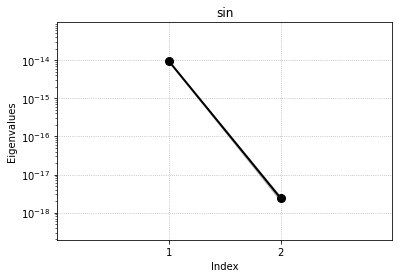

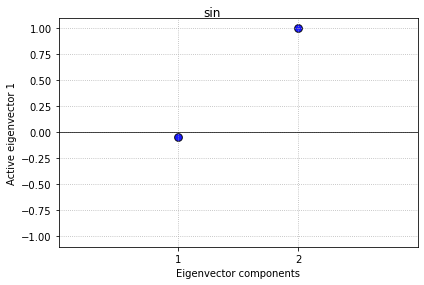

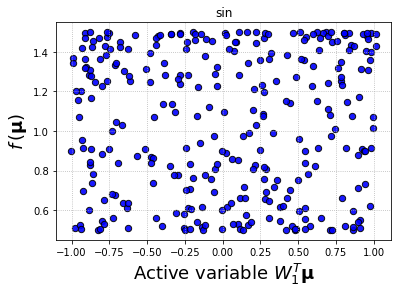

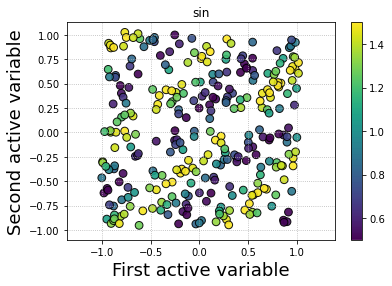

In [6]:
# Compute the active subspace with approximated gradients
asub1 = ActiveSubspaces(dim=1, method='exact', n_boot=100)
asub1.fit(gradients=df_gp)
asub1.plot_eigenvalues(figsize=(6, 4), title=title)
asub1.plot_eigenvectors(figsize=(6, 4), title=title)
asub1.plot_sufficient_summary(x, f, figsize=(6, 4), title=title)

asub2 = ActiveSubspaces(dim=2, method='exact', n_boot=100)
asub2.fit(gradients=df_gp)
asub2.plot_sufficient_summary(x, f, figsize=(6, 4), title=title)

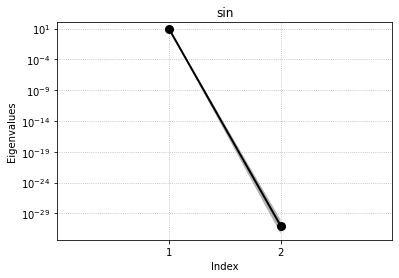

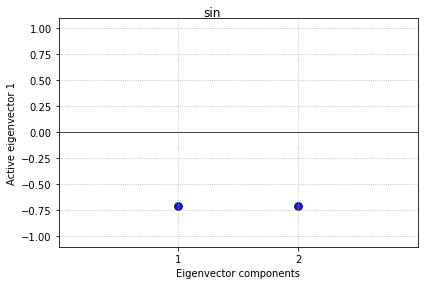

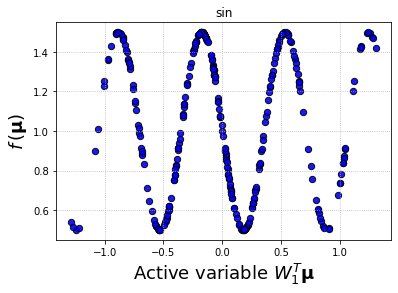

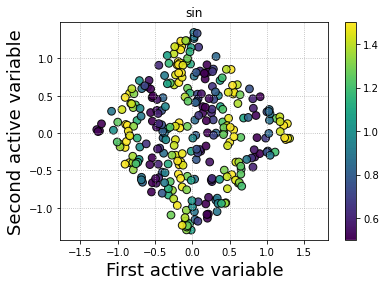

In [7]:
# Compute the active subspace with exact gradients
asub1_ = ActiveSubspaces(dim=1, method='exact', n_boot=100)
asub1_.fit(gradients=df_exact)
asub1_.plot_eigenvalues(figsize=(6, 4), title=title)
asub1_.plot_eigenvectors(figsize=(6, 4), title=title)
asub1_.plot_sufficient_summary(x, f, figsize=(6, 4), title=title)

asub2_ = ActiveSubspaces(dim=2, method='exact', n_boot=100)
asub2_.fit(gradients=df_exact)
asub2_.plot_sufficient_summary(x, f, figsize=(6, 4), title=title)

Perform an analysis of the discrete L1 error between the exact and approximated gradients. As can be seen from the errors plot the gradients are sufficiently accurate only around n_samples=700. Changing the number of samples to this value the active subspace is detected correctly.

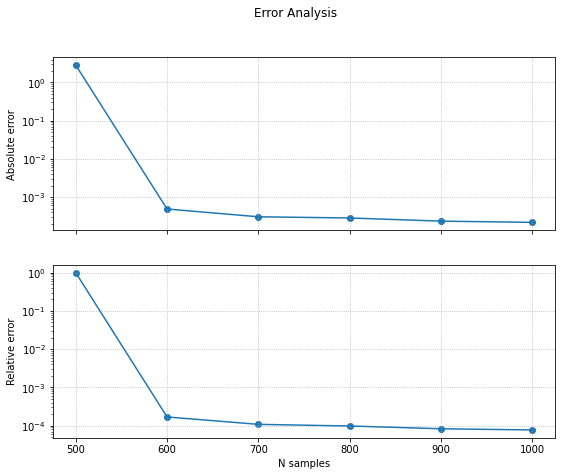

In [8]:
# Error analysis
samples_lis = [500+100*i for i in range(6)]
err_abs, err_rel = [], []
for n_samples in samples_lis:
    X = inputs_uniform(n_samples, input_dim, lb, ub)
    nor = Normalizer(lb, ub)
    x = nor.fit_transform(X)
    f = func(x)
    df_exact = dfunc(x)
    df_gp = eval_gp_grad(x, f, *x.shape)
    absdiff = (1/n_samples)*np.sum(np.linalg.norm(df_exact - df_gp, axis=1))
    err_abs += [absdiff]
    err_rel += [absdiff / ((1/n_samples)*np.sum(np.linalg.norm(df_exact, axis=1)))]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 7))
fig.suptitle('Error Analysis')
axes[0].scatter(samples_lis, err_abs)
axes[0].plot(samples_lis, err_abs)
axes[0].set_ylabel('Absolute error')
axes[1].scatter(samples_lis, err_rel)
axes[1].plot(samples_lis, err_rel)
axes[1].set_ylabel('Relative error')
for i in range(2):
    axes[i].set_yscale('log')
    axes[i].grid(linestyle='dotted')
plt.xlabel('N samples')
plt.show()

### Remarks

Try to change the number of samples such that the gradient's aproximations computed with Gaussian process regression are more accurate and compare qualitatively the approximation errors of the active subspace with the exact gradients.

# Approximation with local linear gradients
Compare the active subspace found with exact gradients and with local linear gradients, see [Constantine, Paul G. active subspaces: emerging ideas for dimension reduction in parameter studies, p.4](https://doi.org/10.1137/1.9781611973860). . 

In [9]:
# Global parameters
n_samples = 300
input_dim = 2

# Generate and normalize inputs
X = inputs_uniform(n_samples, input_dim, lb, ub)
nor = Normalizer(lb, ub)
x = nor.fit_transform(X)

# Define the output of interest and compute the gradients
func = partial(sin_2d, normalizer=nor)
dfunc = egrad(func)

f = func(x)
df_exact = dfunc(x)
title = "sin"

Differently from gradient approximations with Gaussian processes, in this case the results do not show a fictitious active subspace but due to the inaccuracies of the approximations (even for higher number of samples) the exact active subspace is still not detected with a good confidence. Increasing the number of samples to 500 it can be evaluated correctly.

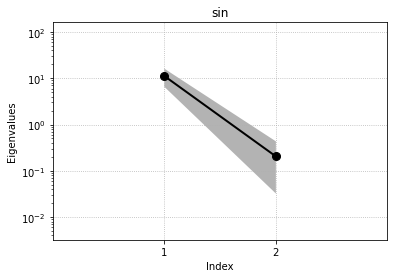

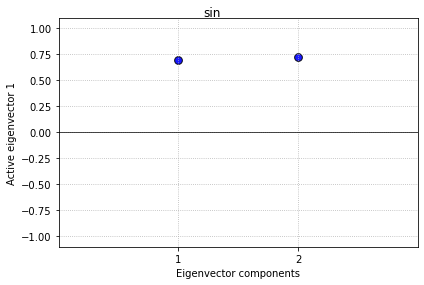

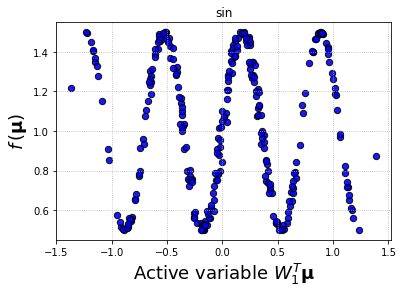

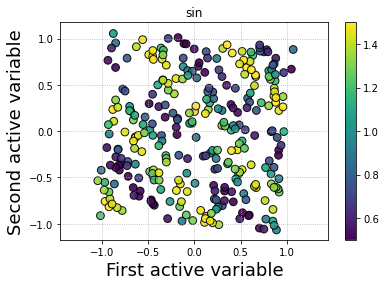

In [10]:
# Compute the active subspace with local_linear_gradients
asub1 = ActiveSubspaces(dim=1, method='local', n_boot=100)
asub1.fit(inputs=x, outputs=f)
asub1.plot_eigenvalues(figsize=(6, 4), title=title)
asub1.plot_eigenvectors(figsize=(6, 4), title=title)
asub1.plot_sufficient_summary(x, f, figsize=(6, 4), title=title)

asub2 = ActiveSubspaces(dim=2, method='local', n_boot=100)
asub2.fit(inputs=x, outputs=f)
asub2.plot_sufficient_summary(x, f, figsize=(6, 4), title=title)

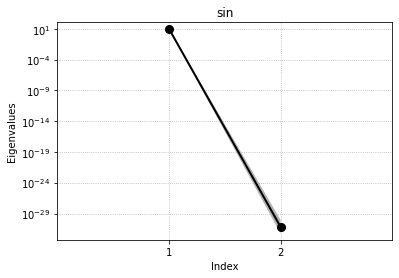

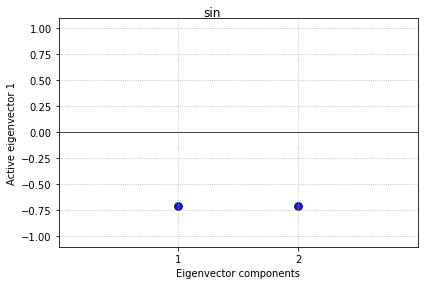

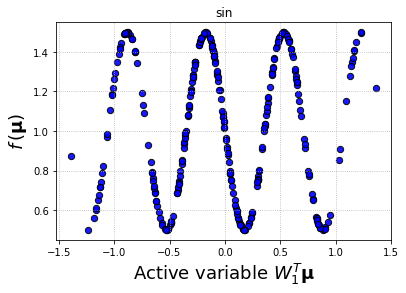

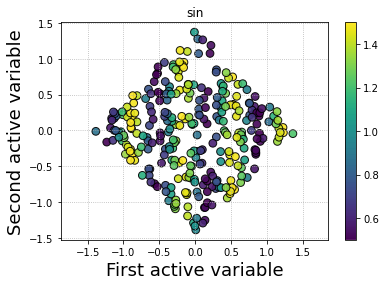

In [11]:
# Compute the active subspace with exact gradients
asub1_ = ActiveSubspaces(dim=1, method='exact', n_boot=100)
asub1_.fit(gradients=df_exact)
asub1_.plot_eigenvalues(figsize=(6, 4), title=title)
asub1_.plot_eigenvectors(figsize=(6, 4), title=title)
asub1_.plot_sufficient_summary(x, f, figsize=(6, 4), title=title)

asub2_ = ActiveSubspaces(dim=2, method='exact', n_boot=100)
asub2_.fit(gradients=df_exact)
asub2_.plot_sufficient_summary(x, f, figsize=(6, 4), title=title)

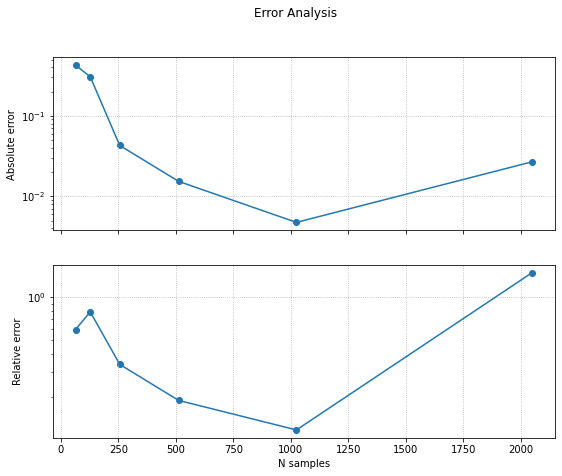

In [12]:
# Error analysis
samples_lis = [2**i for i in range(6, 12)]
err_abs, err_rel = [], []
for n_samples in samples_lis:
    X = inputs_uniform(n_samples, input_dim, lb, ub)
    nor = Normalizer(lb, ub)
    x = nor.fit_transform(X)
    f = func(x)
    ll_gradients, new_inputs = local_linear_gradients(inputs=x, outputs=f)
    df = egrad(func)(new_inputs)
    absdiff = (1/n_samples)*np.sum(np.linalg.norm(df - ll_gradients, axis=1))
    err_abs += [absdiff]
    err_rel += [absdiff / ((1/n_samples)*np.sum(np.linalg.norm(df, axis=1)))]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 7))
fig.suptitle('Error Analysis')
axes[0].scatter(samples_lis, err_abs)
axes[0].plot(samples_lis, err_abs)
axes[0].set_ylabel('Absolute error')
axes[1].scatter(samples_lis, err_rel)
axes[1].plot(samples_lis, err_rel)
axes[1].set_ylabel('Relative error')
for i in range(2):
    axes[i].set_yscale('log')
    axes[i].grid(linestyle='dotted')
plt.xlabel('N samples')
plt.show()

### Remarks

Try to change the number of samples such that the gradient's aproximations with the local linear gradients are more accurate and compare qualitatively the approximation errors of the active subspace with the exact gradients.
